In [44]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer, 
    RobertaModel, 
    RobertaPreTrainedModel,
    RobertaConfig,
    Trainer, 
    TrainingArguments
)
from datasets import Dataset as HFDataset
import tqdm

In [76]:
# Define a custom RoBERTa model for regression
class RobertaForRegression(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        # Load pre-trained RoBERTa
        self.roberta = RobertaModel(config)
        
        # Add a custom regression head
        self.regression_head = nn.Sequential(
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
        # Initialize weights
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, **kwargs):
        
        # Get the output from RoBERTa base model
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds
        )
        
        # Use the [CLS] token representation (first token)
        sequence_output = outputs[0]
        cls_output = sequence_output[:, 0, :]
        
        # Pass through regression head
        logits = self.regression_head(cls_output).squeeze(-1)
        
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
        
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [3]:
def load_dictionary(filename):
    """
    Load a dictionary from a file using pickle.
    
    Args:
        filename (str): The name of the file to load from
        
    Returns:
        dict: The loaded dictionary
    """
    with open(filename, 'rb') as file:
        dictionary = pickle.load(file)
    print(f"Dictionary loaded from {filename}")
    return dictionary

In [4]:
df = pd.read_csv('author_ratings_normalized.csv', lineterminator='\n')

In [5]:
# Create pessimistic target 
a = .05
b = .05
df['reward'] = df['rating_norm'] - a*df['rd_norm'] - b*df['volatility_norm']

Reward statistics:
count    246286.000000
mean          0.456940
std           0.242306
min          -0.039580
25%           0.283523
50%           0.456561
75%           0.636640
max           0.963868
Name: reward, dtype: float64


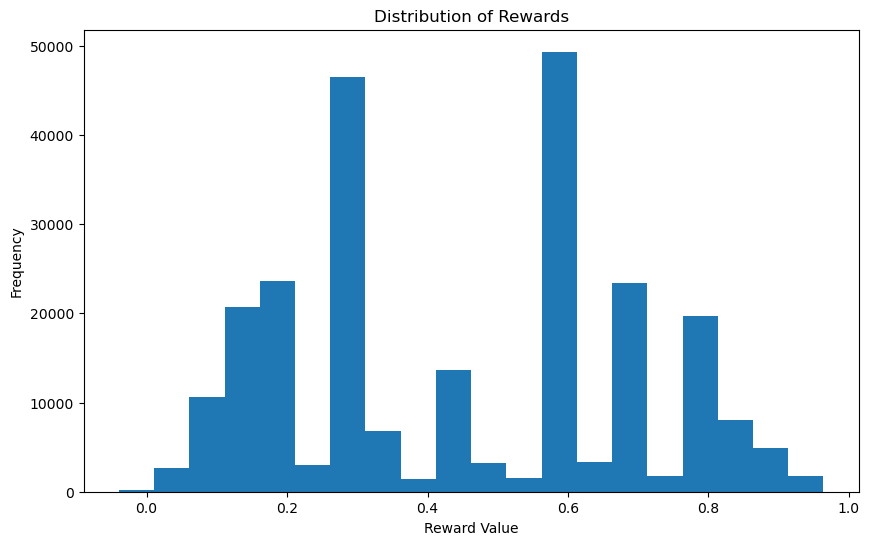

In [6]:
# Ensure column names match expected format
if "question" not in df.columns and "questions" in df.columns:
    df = df.rename(columns={"questions": "question"})
if "answer" not in df.columns and "answers" in df.columns:
    df = df.rename(columns={"answers": "answer"})
if "reward" not in df.columns and "rewards" in df.columns:
    df = df.rename(columns={"rewards": "reward"})

# Display first few rows
df.head()

# Basic statistics of the rewards
print(f"Reward statistics:\n{df['reward'].describe()}")

# Plot reward distribution
plt.figure(figsize=(10, 6))
plt.hist(df['reward'], bins=20)
plt.title('Distribution of Rewards')
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.show()

4. Prepare Data for Training

In [54]:
# Split data into train and validation sets
data_lim = 10000
train_df, eval_df = train_test_split(df.sample(data_lim), test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(eval_df)}")

# Convert to HuggingFace datasets
train_dataset = HFDataset.from_pandas(train_df)
eval_dataset = HFDataset.from_pandas(eval_df)

Training set size: 8000
Validation set size: 2000


5. Prepare Tokenizer and Model

In [77]:
# Load the pre-trained RoBERTa model
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Initialize our custom model
config = RobertaConfig.from_pretrained(model_name)
model = RobertaForRegression.from_pretrained(model_name, config=config)

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all the parameters in the base RoBERTa model
for param in model.roberta.parameters():
    param.requires_grad = False

# Only unfreeze the last transformer layer (optional)
# for param in model.roberta.encoder.layer[-1].parameters():
#     param.requires_grad = True
    
# Make sure the regression head parameters are trainable
for param in model.regression_head.parameters():
    param.requires_grad = True


loading file vocab.json from cache at /home/tsam/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file merges.txt from cache at /home/tsam/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/tsam/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json
loading file tokenizer.json from cache at /home/tsam/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /home/tsam/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaC

In [56]:
# Define tokenization function
def tokenize_function(examples, max_length=512):
    questions = examples["question"]
    answers = examples["answer"]
    
    # Combine question and answer pairs
    texts = [f"Question: {q} Answer: {a}" for q, a in zip(questions, answers)]
    
    # Tokenize the texts
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return tokenized


In [57]:
# Create a new dataset with only the required columns
def prepare_dataset(examples):
    return {
        'input_ids': examples['input_ids'],
        'attention_mask': examples['attention_mask'],
        'labels': examples['reward']
    }

train_dataset_clean = train_dataset.map(
    tokenize_function,
    batched=True
).map(
    prepare_dataset,
    batched=True,
    remove_columns=[col for col in train_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)

eval_dataset_clean = eval_dataset.map(
    tokenize_function,
    batched=True
).map(
    prepare_dataset,
    batched=True,
    remove_columns=[col for col in eval_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)

# Convert to torch tensors
train_dataset_clean.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
eval_dataset_clean.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [31]:
# Enable logging to see progress bar
from transformers import logging
logging.set_verbosity_info()

6. Set up Training Arguments

In [78]:
# Update training arguments
training_args = TrainingArguments(
    output_dir="./results/roberta-reward-model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    # Remove metric_for_best_model completely
    greater_is_better=False,
    push_to_hub=False,
    disable_tqdm=False,
    report_to="none",
    logging_dir="./logs",
    logging_steps=10,
    logging_first_step=True,
)

# Create a compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mse = ((predictions - labels) ** 2).mean().item()
    return {"mse": mse}

# Set up the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_clean,
    eval_dataset=eval_dataset_clean,
    compute_metrics=compute_metrics,
)

/home/tsam/anaconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices


7. Training the Model

In [79]:
# Start the training process
trainer.train()

***** Running training *****
  Num examples = 8,000
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2,500
  Number of trainable parameters = 787,713


Epoch,Training Loss,Validation Loss,Mse
1,0.083300,0.073105,0.073105
2,0.064200,0.063696,0.063696
3,0.060400,0.062158,0.062158
4,0.060000,0.059714,0.059714
5,0.056900,0.058609,0.058609
6,0.058400,0.058791,0.058791
7,0.054400,0.059343,0.059343
8,0.057100,0.058796,0.058796
9,0.062500,0.058654,0.058654
10,0.054900,0.058712,0.058712



***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to ./results/roberta-reward-model/checkpoint-250
Configuration saved in ./results/roberta-reward-model/checkpoint-250/config.json
Model weights saved in ./results/roberta-reward-model/checkpoint-250/model.safetensors

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to ./results/roberta-reward-model/checkpoint-500
Configuration saved in ./results/roberta-reward-model/checkpoint-500/config.json
Model weights saved in ./results/roberta-reward-model/checkpoint-500/model.safetensors

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 32
Saving model checkpoint to ./results/roberta-reward-model/checkpoint-750
Configuration saved in ./results/roberta-reward-model/checkpoint-750/config.json
Model weights saved in ./results/roberta-reward-model/checkpoint-750/model.safetensors

***** Running Evaluation *****
  Num examples = 2000
  Batch

TrainOutput(global_step=2500, training_loss=0.06577547297477722, metrics={'train_runtime': 1874.1857, 'train_samples_per_second': 42.685, 'train_steps_per_second': 1.334, 'total_flos': 2.12420947968e+16, 'train_loss': 0.06577547297477722, 'epoch': 10.0})

In [34]:
# Function to predict rewards for new question-answer pairs
def predict_reward(question, answer, model, tokenizer):
    # Combine question and answer
    text = f"Question: {question} Answer: {answer}"
    
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        # If using our custom model directly
        if isinstance(outputs, tuple):
            predicted_reward = outputs[1].item()
        else:
            predicted_reward = outputs.item()
    
    return predicted_reward

8. Save the Fine-tuned Model

In [35]:
# Save the model and tokenizer
model_save_path = "./roberta-reward-model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Configuration saved in ./roberta-reward-model/config.json
Model weights saved in ./roberta-reward-model/model.safetensors
tokenizer config file saved in ./roberta-reward-model/tokenizer_config.json
Special tokens file saved in ./roberta-reward-model/special_tokens_map.json


Model saved to ./roberta-reward-model


9. Evaluate the Model on Test Data

In [36]:
# Get evaluation metrics
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


Evaluation results: {'eval_loss': 0.00281264865770936, 'eval_mse': 0.00281264865770936}


10. Using the Model for Prediction

In [49]:
# Function to predict rewards for new question-answer pairs
def predict_reward(question, answer, model, tokenizer, device=None):
    # Determine the device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Make sure model is on the correct device
    model = model.to(device)
    
    # Combine question and answer
    text = f"Question: {question} Answer: {answer}"
    
    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    # Move inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        # Handle different output formats
        if isinstance(outputs, dict):
            predicted_reward = outputs["logits"].cpu().item()
        elif isinstance(outputs, tuple):
            predicted_reward = outputs[1].cpu().item()
        else:
            predicted_reward = outputs.cpu().item()
    
    return predicted_reward

In [50]:
def batch_predict_rewards(questions, answers, model, tokenizer, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    predictions = []
    
    for i in range(0, len(questions), batch_size):
        batch_questions = questions[i:i+batch_size]
        batch_answers = answers[i:i+batch_size]
        
        batch_texts = [f"Question: {q} Answer: {a}" for q, a in zip(batch_questions, batch_answers)]
        
        inputs = tokenizer(
            batch_texts,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        
        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            if isinstance(outputs, dict):
                batch_preds = outputs["logits"].cpu().numpy()
            elif isinstance(outputs, tuple):
                batch_preds = outputs[1].cpu().numpy()
            else:
                batch_preds = outputs.cpu().numpy()
                
        predictions.extend(batch_preds.flatten().tolist())
    
    return predictions

In [80]:
# Try with some sample questions and answers
sample_questions = [
    "What is the capital of France?",
    "How does photosynthesis work?",
    "What is the meaning of life?"
]

sample_answers = [
    "Paris is the capital of France.",
    "Photosynthesis is the process where plants convert sunlight, water and carbon dioxide into oxygen and glucose.",
    "The meaning of life is a philosophical question that has been debated for centuries."
]

# Make predictions
for q, a in zip(sample_questions, sample_answers):
    reward = predict_reward(q, a, model, tokenizer)
    print(f"Question: {q}")
    print(f"Answer: {a}")
    print(f"Predicted reward: {reward:.4f}\n")

Question: What is the capital of France?
Answer: Paris is the capital of France.
Predicted reward: 0.4592

Question: How does photosynthesis work?
Answer: Photosynthesis is the process where plants convert sunlight, water and carbon dioxide into oxygen and glucose.
Predicted reward: 0.4352

Question: What is the meaning of life?
Answer: The meaning of life is a philosophical question that has been debated for centuries.
Predicted reward: 0.4717



11. Visualize Predicted vs. Actual Rewards

In [81]:
# Get predictions for the validation set
def get_predictions(dataset, model, tokenizer):
    predictions = []
    actual = []
    
    for i in range(len(dataset)):
        example = dataset[i]
        question = example['question']
        answer = example['answer']
        reward = example['reward']
        
        pred_reward = predict_reward(question, answer, model, tokenizer)
        predictions.append(pred_reward)
        actual.append(reward)
    
    return predictions, actual

# Sample a subset for visualization (to avoid long processing time)
sample_size = min(100, len(eval_dataset))
sampled_eval = eval_dataset.select(range(sample_size))

# Get predictions
predicted_rewards, actual_rewards = get_predictions(sampled_eval, model, tokenizer)

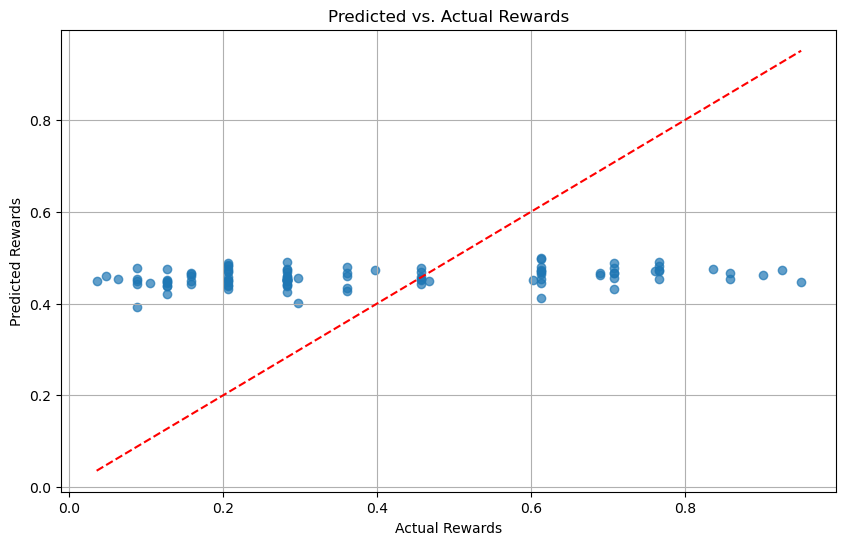

Mean Squared Error: 0.0630
Mean Absolute Error: 0.2261
R² Score: -0.0360


In [82]:
# Plot predicted vs. actual rewards
plt.figure(figsize=(10, 6))
plt.scatter(actual_rewards, predicted_rewards, alpha=0.7)
plt.plot([min(actual_rewards), max(actual_rewards)], 
         [min(actual_rewards), max(actual_rewards)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs. Actual Rewards')
plt.grid(True)
plt.show()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_rewards, predicted_rewards)
mae = mean_absolute_error(actual_rewards, predicted_rewards)
r2 = r2_score(actual_rewards, predicted_rewards)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")